# Unemployment assignment
--- 
**Description**

The UnemploymentSpain.dat dataset contains the unemployment figures for Spain for every month between January 2001 and October 2022. The total unemployment is given

**Tasks**
- Identify the best Seasonal ARIMA model to forecast the total unemployment rate.
- Identify the best SARIMAX model to forecast the total unemployment rate accounting for the COVID-19 period using an *intervention variable*.
- Compare both models.
- Apply nonlinear techniques for forecasting the unemployment
- Obtain the best forecast for the unemployment rate of November 2022 

Write a report describing the process followed for each task.

--- 

In [3]:
### Load libraries ###

# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller

from sklearn.neural_network import MLPRegressor
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn import set_config
set_config(display='diagram')
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})


# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
import scipy as sp

# Statsmodels time series 
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime
import scipy.stats as st

torch installation could not be found, only numpy activation functions allowed


---
## 1. Read the dataset

Indicamos que la variable date tiene fechas (parse_dates), para decirle que no es una variable mas sino que es un indice de fechas. 

Al leer el df, no lo configuramos como una variable más sino como un indice. 

In [25]:
# Import data
dateparse = lambda x :datetime.strptime(x ,"%d/%m/%Y")

df = pd.read_csv('UnemploymentSpain.dat',sep='\t', parse_dates=['DATE'], dayfirst=True, date_parser=dateparse, index_col='DATE')

df.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


In [5]:
df.shape

(262, 2)

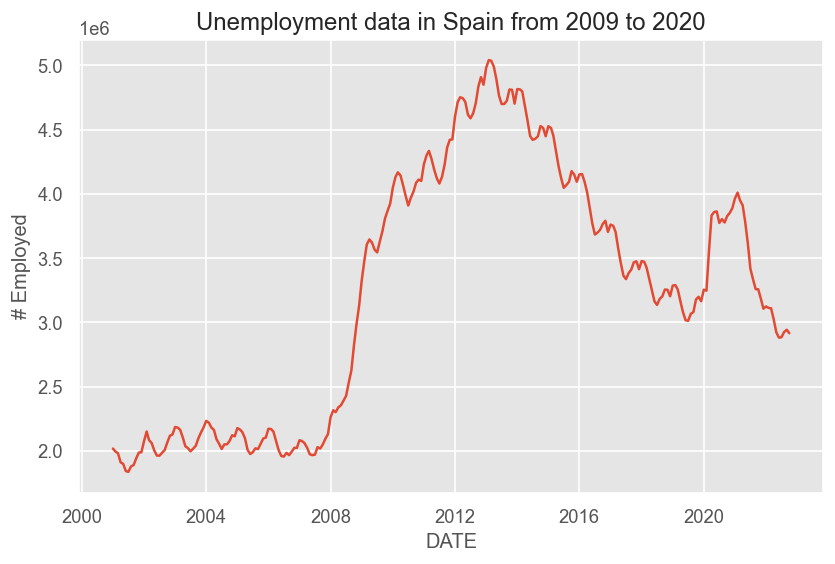

In [26]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from 2009 to 2020', xlabel='DATE', ylabel='# Employed')
plt.show()

Vemos que no hay constancia ni en la media ni en la varianza, por lo que deberemos estabilizarlas.

Viendo esta serie, aun no puedo saber si es autorregresiva, ruido blanco o lo que sea.

In [27]:
df_unemployment = df[['TOTAL']] # Maintain data.frame format for column
df_unemployment

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
...,...
2022-06-01,2880582
2022-07-01,2883812
2022-08-01,2924240


---
### Identification process

Con esta funcion, lo que estamos pintando es la serie original y las funciones de correlacion simple parcial (acf y pacf)

Los pasos a seguir son:
- 1. Identificacion (ACF yPACF)
- 2. Diagnostico
    
#### 1. Plot the series and search for possible outliers

En primer llugar pintamos la serie, viendo la correlacion vemos que tiene pinta de que la media no es estacionaria

Para comprobar la varianza, deberemos pintar Box Cox

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


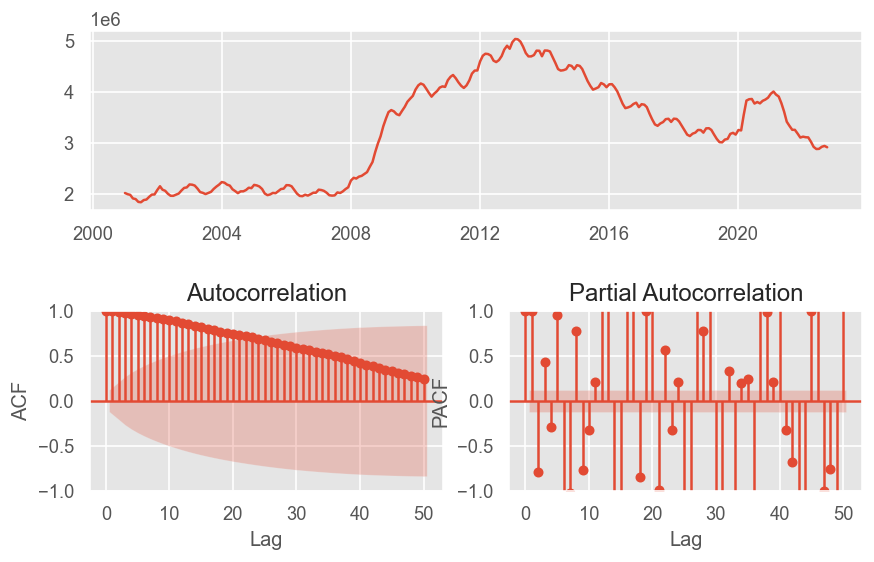

In [29]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_unemployment,lags=50)

Para pintar la siguiente gráfica, en un primer momento no sabremos cómo establecer la estacionalidad. Pondremos un número aleatorio (que creamos que tenga sentido), y estabilizaremos la varianza con ese numero.

Una vez pintemos la diferenciacion estacional (tras ejecutar boxcox para estabilizar la varianza), podremos ver la tendencia que sigue la serie en el grafico de Autocorrelacion. Mirando los picos de ese gráfico, podemos sacar la estacionalidad.

Una vez averiguada la estacionalidad real de la serie, deberemos repetir el proceso de transformacion BoxCox, pero esta vez introduciendo la estacionalidad correcta averiguada.

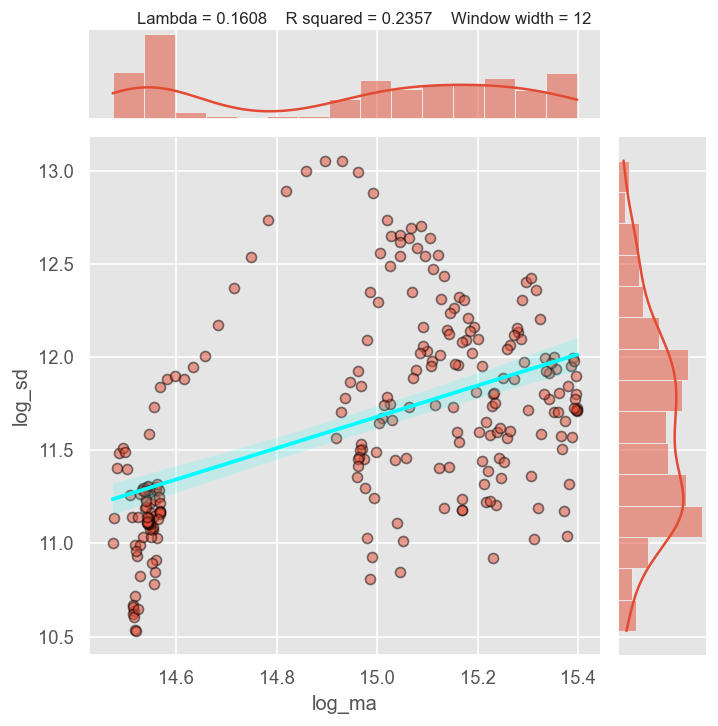

0.1607915855603168

In [31]:
FT.boxcox_lambda_plot(df_unemployment, window_width=12)

De la gráfica anterior podemos sacar el valor de lambda, que deberemos introducir en la funcion BoxCox para estabilizar la varianza

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


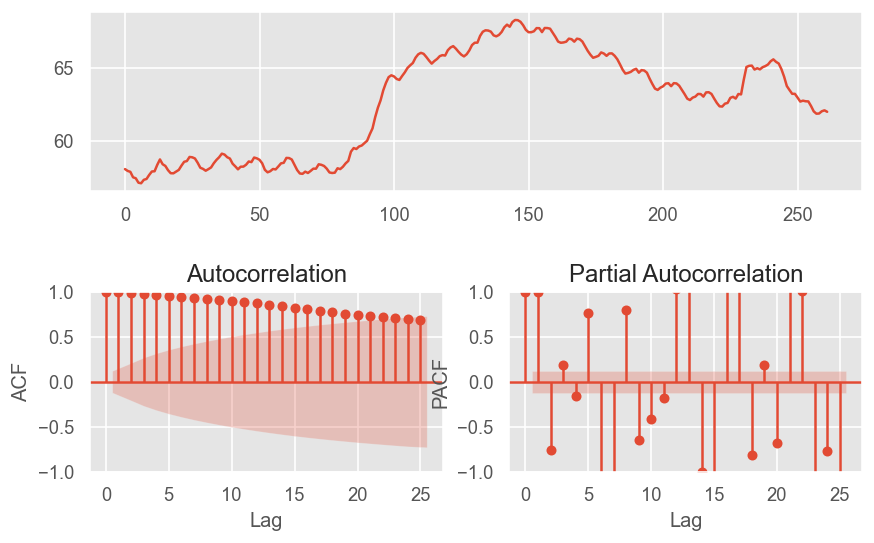

In [32]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.161 #Select lambda
    z = st.boxcox(df_unemployment.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_unemployment.columns.values.tolist())
else:
    z = df_unemployment

# Plot transformed data
FT.ts_display(z)

Una vez estabilizada la varianza, tengo que analizar la parte estacionaria. Si nos fijamos, vemos que claramente tenemos que diferenciar la media.

A continuacion, pintamos de nuevo la distribucion de la varianza. Vemos que ahora es una linea horizontal y que, además, el valor de lambda es muy cercano a 1. Esto nos indica que se ha estabilizado correctamente.

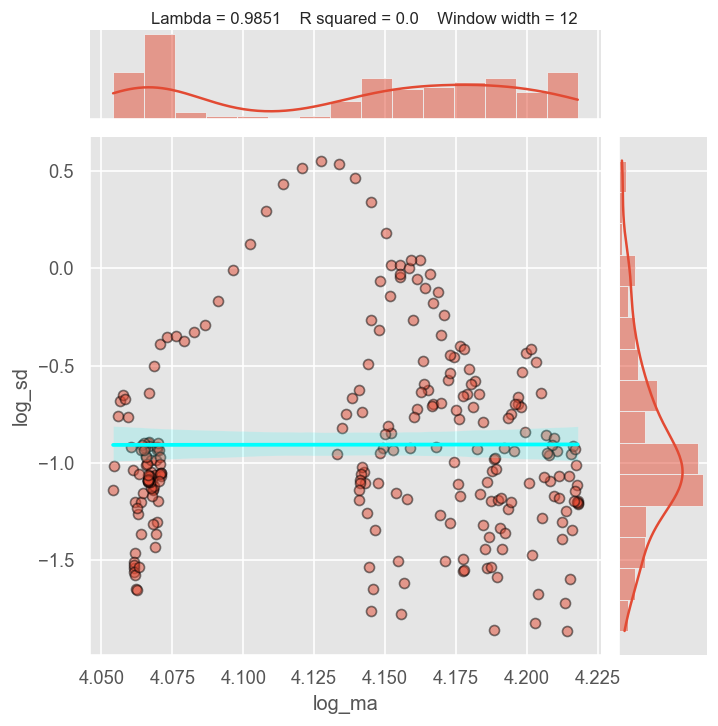

0.9850716550948463

In [33]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

Vamos a aplicar el test Dickey Fuller para asegurarnos de que tenemos que diferenciar la media. Si obtenemos un pvalor mayor que 0.05, significará que debemos realizar al menos una diferenciacion.


In [34]:
# Alternative test - Augmented Dickey Fuller Test
# Aplicando este test, podemos saber si debemos realizar diferenciacion para la media o no. Si el pvalor es mayor de 0.05, se realiza diferenciacion
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.644424
p-value: 0.459950
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


Como el pvalor es mayor que 0.05, se realiza diferenciacion en la media. (d =1)

*Nota*: En primer lugar vemos que con D = 0, obtenemos un seasonality de 12 (hay un pico cada 12 puntos) Debemos hacer esto para establecer la seasonality. Lo hacemos con 0 para ver, y luego ya hacemos la transformacion boxcox con la seasonality que hayamos descubierto en este gráfico

`Diferenciacion en la media:`

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


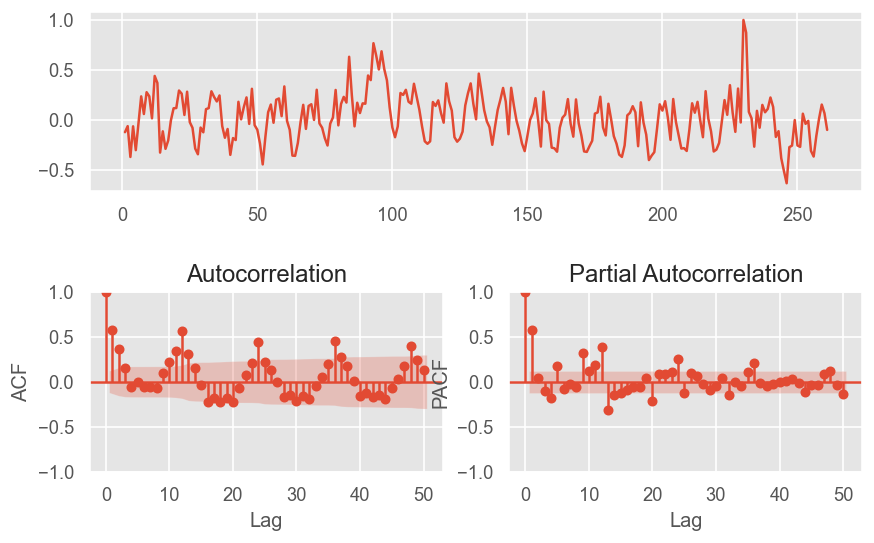

In [38]:
# Difference of the time series
d = 1 # diferenciacion regular. y(t)-y(t-q). Incremento respecto del instante anterior
D = 0 # Diferenciacion estacional. Voy a obtener una nueva serie que es y(t)- y(t-s). Incremento respecto del periodo anterior
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Al hacer una diferenciacion de la media (d=1) vemos que se estabiliza (primer gráfico), pero la serie no es estacionaria igualmente, puesto que las autocorrelaciones no decrecen. Esto significa que debemos aumentar la correlacion estacional (D=1)

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


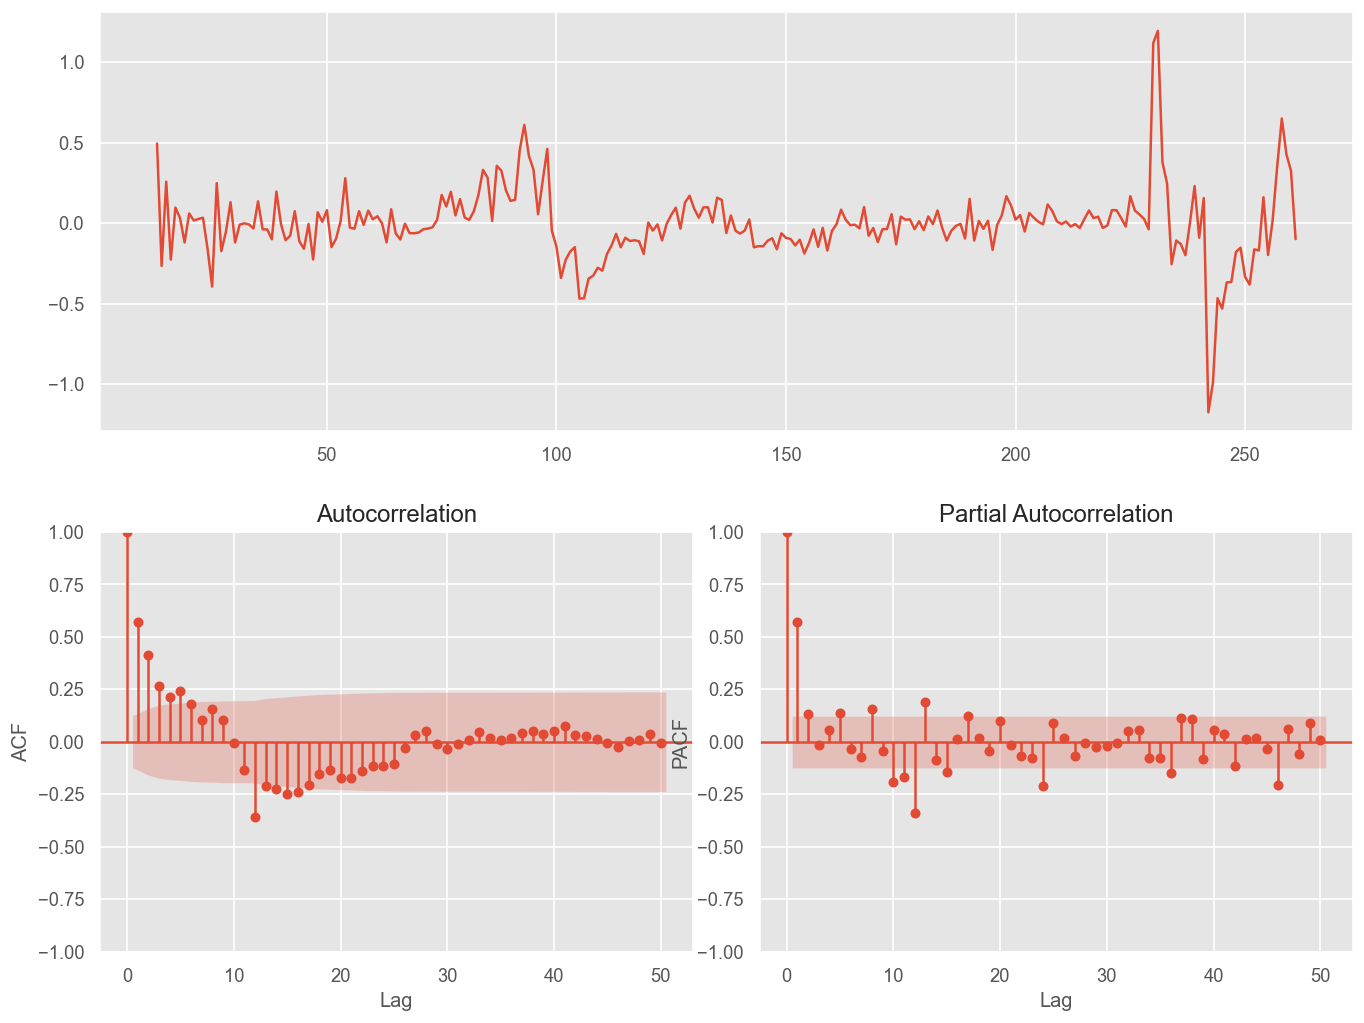

In [41]:
# Difference of the time series
d = 1 # diferenciacion regular. y(t)-y(t-q). Incremento respecto del instante anterior
D = 1 # Diferenciacion estacional. Voy a obtener una nueva serie que es y(t)- y(t-s). Incremento respecto del periodo anterior
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values

plt.rcParams.update({'figure.figsize': (12, 9), 'figure.dpi': 120})
FT.ts_display(Bz,lags=50)

Como podemos ver en la gráfica anterior, una vez aumentada la correlacion estacional (D=1), vemos que tanto la tendencia estacional como la periodica está disminuyendo, por lo que ya tenemos la serie como queríamos y podemos empezar a ajustar el modelo de arima. 

#### 5. Fit ARIMA model and check significance of the coefficients

Vamos a analizar los gráficos de ACF y PACF obtenidos anteriormente para establecer los mejores parámetros para ajustar nuestro modelo.
- Fijandonos en la parte regular tenemos dos opciones:
    - ACF 3 o 4, lo que implica un MA de orden 3 (más simple)
    - PACF 1 o 2, lo que implica un AR de orden 1

    Empezaremos por probar el modelo más simple (AR de orden 1), para ver como se ajusta.


- Fijandonos en la parte estacional. (Barras localizadas en los multiplos de 12 (seasonality))
    - En primer lugar hemos comprobado que queremos diferenciar (para conseguir decrecer la autocorrelacion)
    - ACF de orden 1 (Una unica barra en el 12) --> MA de orden 1
    - PACF de orden 2 o 3 (Barras en 12, 24 y puede que 36) --> AR de orden 2
    - Seasonality de 12, como ya hemos visto

    Al igual que en la parte regular, comenzaremos probando el modelo más simple (MA de orden 1), para ver cómo se comportan las predicciones


In [42]:
# Fit model with estimated order
'''
AR --> (p) PACF
MA --> (q) ACF
Orden --> (p,d,q)
'''
sarima_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components (p,d,q) --> en el d ponemos un 1 porque hemos decidido diferenciar. AR(1)
                    seasonal_order=(0, 1, 1, 12),  # Seasonal components [P,D,Q,S] --> Estacionales - MA(1)
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 128.453
Date:                              Fri, 25 Nov 2022   AIC                           -250.905
Time:                                      11:46:32   BIC                           -240.514
Sample:                                           0   HQIC                          -246.716
                                              - 262                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6786      0.028     23.950      0.000       0.623       0.734
ma.S.L12      -0.84

Ajustando el modelo vemos que los pvalores de todos los coeficientes son son 0, lo cual es buena señal. A su vez, obtenemos un AIC negativo.

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.370812    0.82625


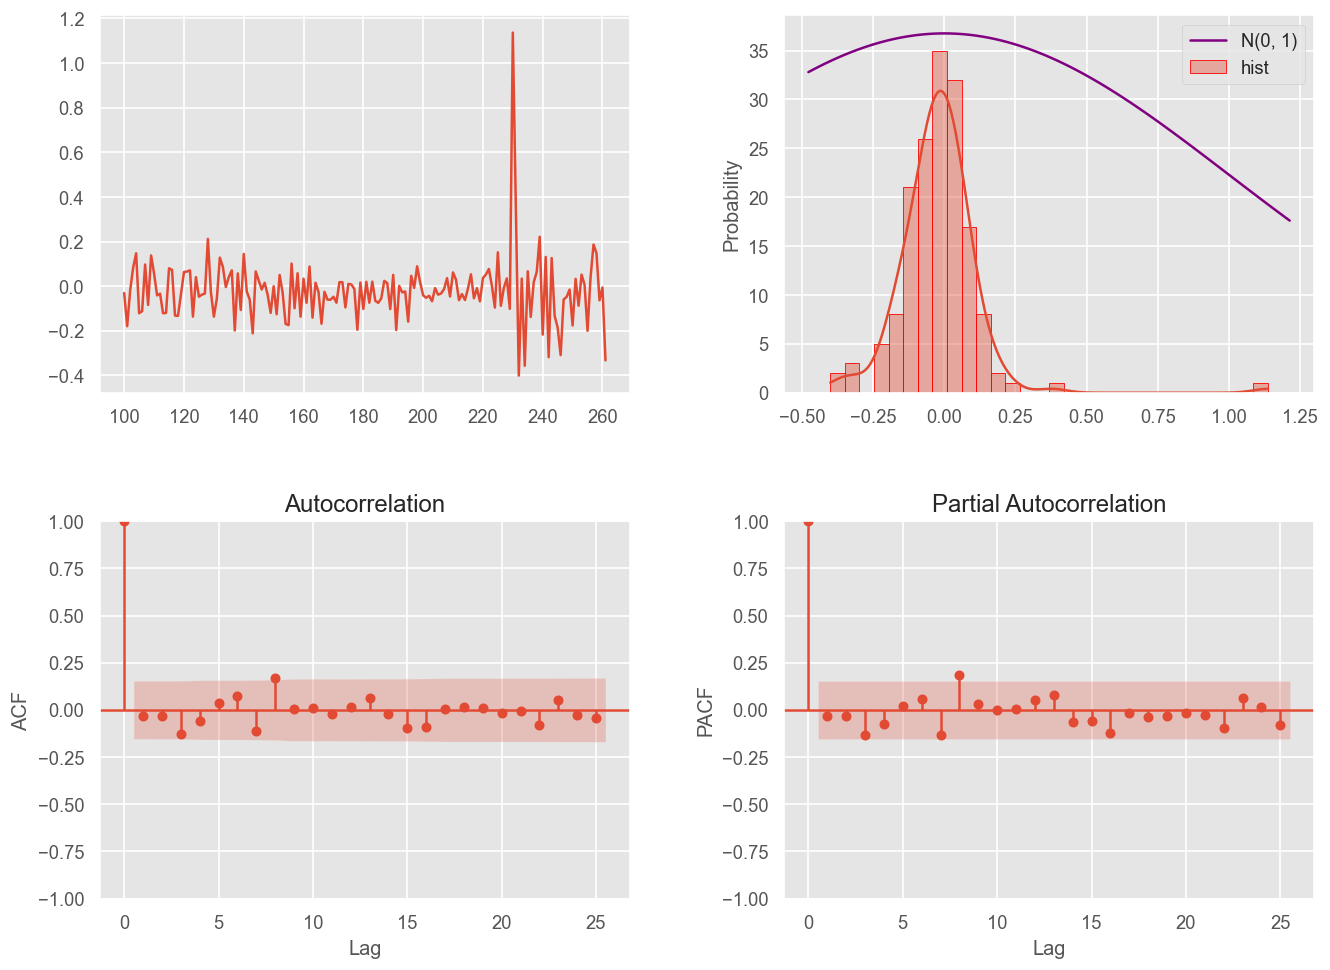

In [43]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

Al pintar los residuos vemos que prácticamente hemos obtenido ruido blanco (errores de mi modelo que asumo porque no soy capaz de modelar), por lo que deducimos que es un buen modelo.

A continuacion, vamos a realizar las predicciones para el mes que viene con el modelo que hemos entrenado.

In [78]:
df_unemployment = df_unemployment.reset_index()
df_unemployment

,DATE,TOTAL
0,2001-01-01,2017389
1,2001-02-01,1993273
2,2001-03-01,1981006
3,2001-04-01,1910453
4,2001-05-01,1898285
...,...,...
257,2022-06-01,2880582
258,2022-07-01,2883812
259,2022-08-01,2924240
260,2022-09-01,2941919


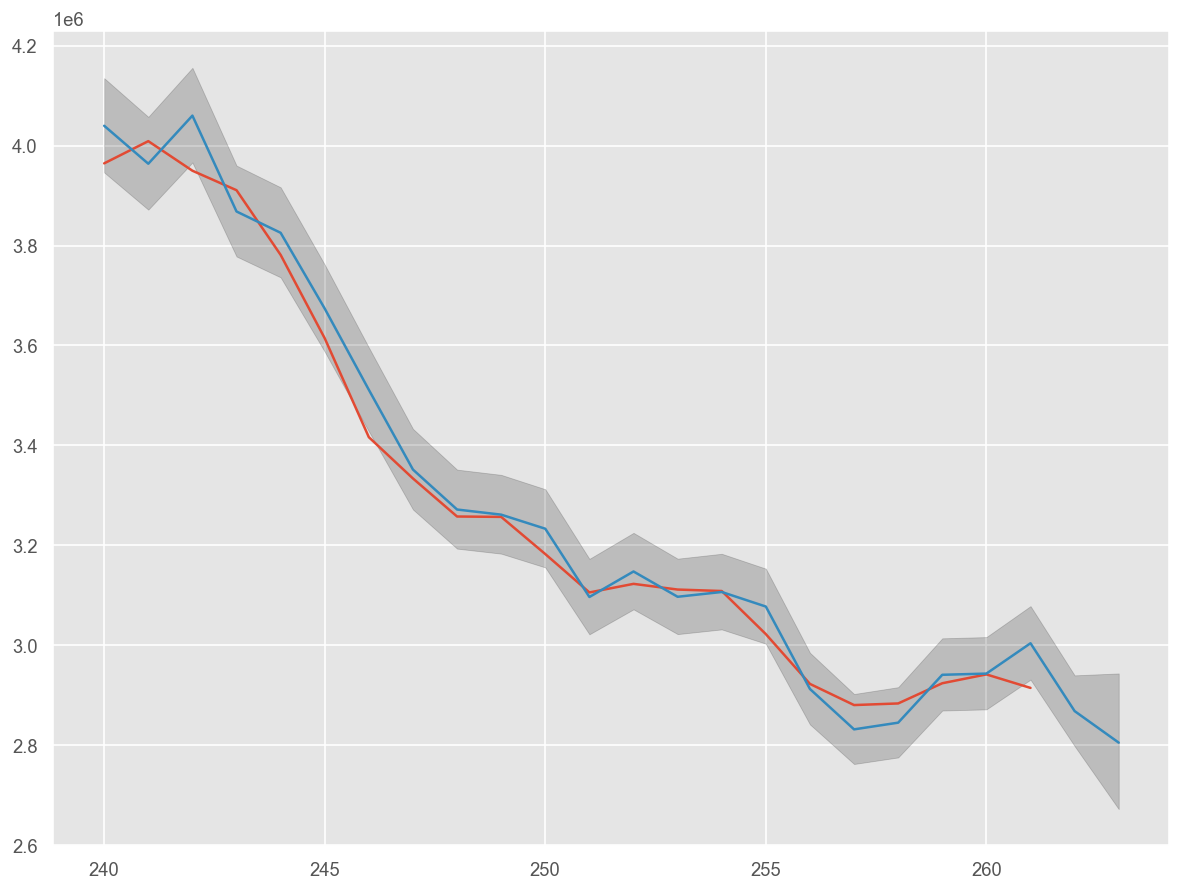

In [80]:
#Obtain forecasts for in-sample and out-of-sample
start = 240
horizon = 1
end = df_unemployment["TOTAL"].shape[0] + horizon

pred = sarima_fit.get_prediction(start = start, end=end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

# Obtener las fechas de la prediccion (indice de fecha en nuestro df)
# dates_to_plot = []
# for i in range(1, (horizon+1)):
#     d = df_unemployment.index[-1] + pd.DateOffset(months=i)
#     dates_to_plot.append(d)
# yhat.index = dates_to_plot
# yhat_conf_int = dates_to_plot

# initial_date = "2020-01-01"

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_unemployment["TOTAL"].loc[start:])
plt.plot(yhat)

In [88]:
# ¿Cómo hacemos para sacar el numero de la prediccion?
num_parados_noviembre = yhat.iloc[-1]
print(f"Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: {num_parados_noviembre} personas")

Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: 2805379.798921724
